In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
from math import sqrt

# Task 1: maximum likelihood fit.


Let's generate a Gaussian mixture dataset and then fit its parameters with maximum likelihood.

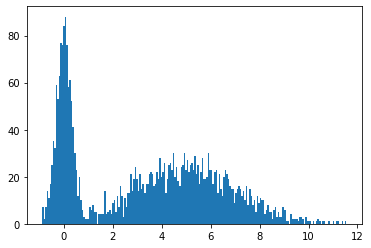

In [ ]:
X1 = np.random.normal(size=1000, scale=0.3).astype('float32')
X2 = np.random.normal(size=2000, loc=5., scale=2.).astype('float32')

X = np.concatenate([X1, X2])
np.random.shuffle(X)

plt.hist(X, bins=200);

**Task**:
 - fill the gaps below to perform the max. likelihood fit with the pdf:
$$\text{PDF}(x|\mu_1, \sigma^2_1, \mu_2, \sigma^2_2, \alpha)
= \alpha\cdot\mathscr{N}(x|\mu_1, \sigma_1^2) + (1 - \alpha)\cdot\mathscr{N}(x|\mu_2, \sigma_2^2)$$
 - what the fitted values of $\mu_1, \sigma^2_1, \mu_2, \sigma^2_2$ and $\alpha$ should be? does your fit converge to them?

all right


IndexError: ignored

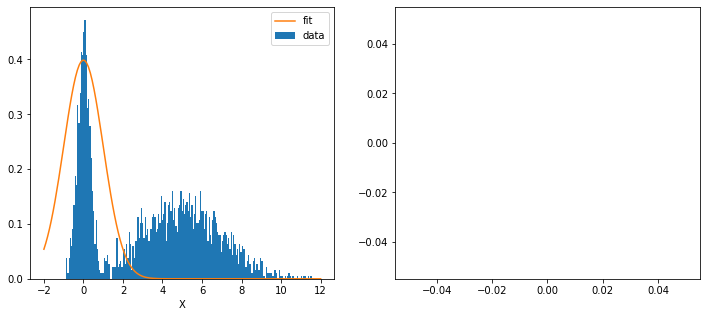

In [ ]:
from IPython.display import clear_output

# Defining Gaussian PDF using torch functions
def gaussian(x, mu, sigma):
  return  torch.exp(-0.5*(x/sigma)**2) / (sigma * np.sqrt(np.pi*2))

# Arbitrary mixture PDF
def mixture(x, f1, f2, alpha):
  return alpha * f1(x) + (1. - alpha) * f2(x)

# Parameters that we'd like to infer (with an initial guess)
m1    = torch.Tensor([1.0])
m2    = torch.Tensor([4.0])
s1    = torch.Tensor([1.0])
s2    = torch.Tensor([1.0])
alpha = torch.Tensor([0.5])

# At each gradient update we'll apply this function to
# ensure valid parameter values
def apply_constraints():
    if s1 and alpha >0 and alpha <1 and s2 >= 1e-5:
      print('all right')
    else:
      print('not apply constraints')


variables = [m1, m2, s1, s2, alpha]

# Defining the overall PDF
def model_pdf(x):
  return mixture(x,
                 lambda t: gaussian(t, m1, s1),
                 lambda t: gaussian(t, m2, s2),
                 alpha)

# Log likelihood
def loglike(x):
  return torch.log(model_pdf(x))

learning_rate = 0.0001
grad_history = [] # to keep track of gradient values at different steps

for i in range(30):
  # Forward pass:
  l = loglike(X)
  
  # Backprop
  # Gradient ascent step
  apply_constraints()
  ############################
  # Do some plotting
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.hist(X, bins=200, density=True, label='data')
  x_grid = np.linspace(-2, 12, 150)
  plt.plot(x_grid, model_pdf(x_grid), label='fit')
  plt.legend()
  plt.xlabel('X')

  plt.subplot(1, 2, 2)
  lines = plt.plot(np.array(grad_history))
  low = min(grad_history[-1])
  high = max(grad_history[-1])
  plt.ylim(low  - (high - low) * 0.6,
           high + (high - low) * 0.6)
  plt.legend(lines, ['m1', 'm2', 's1', 's2', 'alpha'])
  plt.xlabel('step')
  plt.ylabel('gradient')
  plt.show()
  clear_output(wait=True);

# Task 2: classifying clothes


In [100]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)

[['Bag' 'Bag' 'Ankle boot' 'Coat' 'Sandal' 'Pullover' 'Sneaker'
  'Ankle boot']
 ['Bag' 'Sandal' 'Ankle boot' 'Sandal' 'Trouser' 'T-shirt/top' 'Coat'
  'Coat']
 ['Sandal' 'T-shirt/top' 'Bag' 'Dress' 'Sandal' 'Ankle boot' 'Pullover'
  'Dress']
 ['T-shirt/top' 'Shirt' 'Ankle boot' 'Sneaker' 'Dress' 'Coat' 'Bag' 'Bag']
 ['Ankle boot' 'Dress' 'Shirt' 'T-shirt/top' 'Sandal' 'Trouser' 'Coat'
  'T-shirt/top']
 ['Pullover' 'Coat' 'Dress' 'Shirt' 'Sandal' 'Sneaker' 'T-shirt/top'
  'Pullover']
 ['T-shirt/top' 'Sandal' 'Dress' 'Trouser' 'Bag' 'Dress' 'Ankle boot'
  'Sandal']
 ['Sneaker' 'Coat' 'Ankle boot' 'Sneaker' 'Dress' 'Ankle boot' 'Bag'
  'Shirt']]


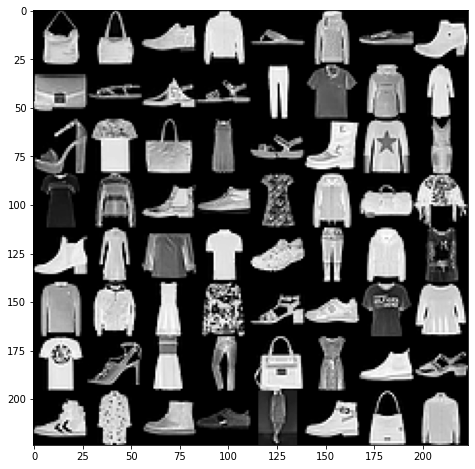

In [101]:
# Array for decoding the categories
label_names = np.array(['T-shirt/top',
                        'Trouser',
                        'Pullover',
                        'Dress',
                        'Coat',
                        'Sandal',
                        'Shirt',
                        'Sneaker',
                        'Bag',
                        'Ankle boot'])

# Get a single data batch of 64 images
sample_images, sample_labels = next(iter(trainloader))

# Plot the images in a 8x8 grid
plt.figure(figsize=(8, 8))
plt.imshow(
    sample_images.numpy().reshape(8, 8, 28, 28).transpose((0, 2, 1, 3)).reshape(224, 224),
    cmap='gray'
)
# Print corresponding labels
print(label_names[sample_labels.numpy().reshape(8, 8)])

**Task**:

Train a model which is an average of two models with different numbers of layers on the Fashion MNIST dataset, e.g.:

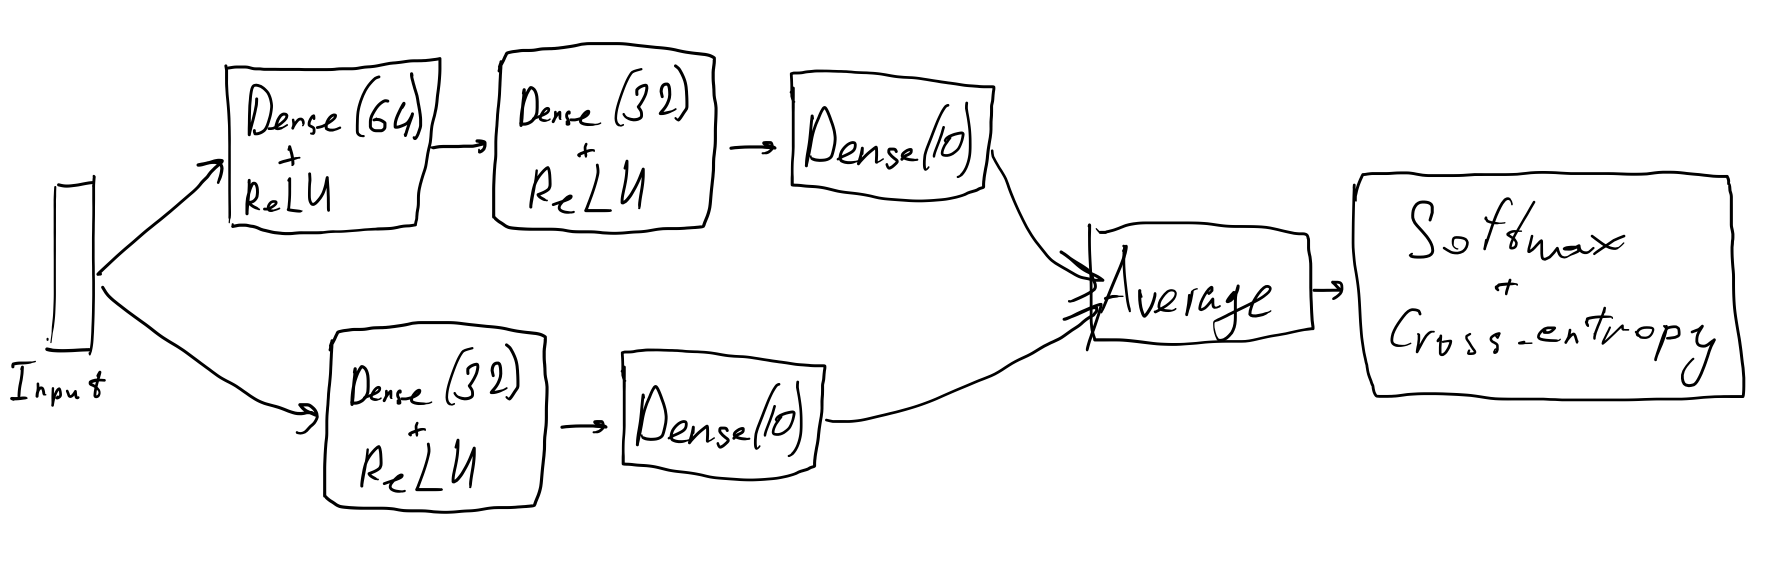

In [102]:
import torch 
from torchvision import transforms,datasets
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt 
import numpy as np 


In [103]:
transform=transforms.Compose([transforms.ToTensor()])

In [104]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)        
        x=self.dropout(F.relu(self.fc1(x)))
        x=self.dropout(F.relu(self.fc2(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,512)
    self.fc2=nn.Linear(512,256)
    self.out=nn.Linear(256,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x = self.dropout(x)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x

In [105]:
model_1=FNet()
model_2=convNet()
def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
model_1.apply(weight_init_normal),model_2.apply(weight_init_normal)
use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()


print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  False


In [ ]:
criterion=nn.CrossEntropyLoss()

In [ ]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=50

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in trainloader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in testloader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(trainloader)
        valid_loss = valid_loss/len(testloader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
            z=type(model).__name__
            torch.save(model.state_dict(), z+'_model.pth')
            valid_loss_min=valid_loss
    return(loss_keeper)

In [ ]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.41178072855543735	Validation Loss : 0.3909854970540211
Validation loss decreased from : inf ----> 0.3909854970540211 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3707257712017626	Validation Loss : 0.36195647612119175
Validation loss decreased from : 0.3909854970540211 ----> 0.36195647612119175 ----> Saving Model.......

Epoch : 3	Training Loss : 0.3457675905131709	Validation Loss : 0.3724826818249028

Epoch : 4	Training Loss : 0.33142799560798764	Validation Loss : 0.36531217177962044

Epoch : 5	Training Loss : 0.31632164138148844	Validation Loss : 0.34938550916067357
Validation loss decreased from : 0.36195647612119175 ----> 0.34938550916067357 ----> Saving Model.......

Epoch : 6	Training Loss : 0.3054203380510878	Validation Loss : 0.3418660494172649
Validation loss decreased from : 0.34938550916067357 ----> 0.3418660494172649 ----> Saving Model.......

Epoch : 7	Training Loss : 0.2948339637964646	Validation Loss : 0.34544105903737865

Epoch : 8	

In [ ]:
m1_loss

{'train': [0.41178072855543735,
  0.3707257712017626,
  0.3457675905131709,
  0.33142799560798764,
  0.31632164138148844,
  0.3054203380510878,
  0.2948339637964646,
  0.2841130268456204,
  0.28048612534809214,
  0.275028976645551,
  0.267115537875465,
  0.26315630447349825,
  0.25494297978672775,
  0.24768492418216237,
  0.2448443863580603,
  0.24116657139745348,
  0.23585052633765283,
  0.23180494302593824,
  0.2263280165586263,
  0.22444349450311427,
  0.21910513916821367,
  0.2177143303959418,
  0.21442249683397158,
  0.21051598390314116,
  0.2102031458669634,
  0.20988805833528798,
  0.20453466076268825,
  0.19974640736193544,
  0.1947003550478009,
  0.19824256656615974,
  0.1913944043790989,
  0.19091848149768578,
  0.18755670816802394,
  0.1866277943271945,
  0.18330602843497099,
  0.18184799798079201,
  0.1815578839076417,
  0.17609740662247514,
  0.17684559378304335,
  0.17793624173762448,
  0.1738209966411278,
  0.1712072644986387,
  0.16733784249016662,
  0.16999577017906092

In [ ]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.46400297625359693	Validation Loss : 0.3319803535178968
Validation loss decreased from : inf ----> 0.3319803535178968 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3120135164845473	Validation Loss : 0.2823337753107593
Validation loss decreased from : 0.3319803535178968 ----> 0.2823337753107593 ----> Saving Model.......

Epoch : 3	Training Loss : 0.26677301503829104	Validation Loss : 0.2727929119756267
Validation loss decreased from : 0.2823337753107593 ----> 0.2727929119756267 ----> Saving Model.......

Epoch : 4	Training Loss : 0.23655321984800068	Validation Loss : 0.25190291591700475
Validation loss decreased from : 0.2727929119756267 ----> 0.25190291591700475 ----> Saving Model.......

Epoch : 5	Training Loss : 0.21186887016936914	Validation Loss : 0.237276511658339
Validation loss decreased from : 0.25190291591700475 ----> 0.237276511658339 ----> Saving Model.......

Epoch : 6	Training Loss : 0.19423589260100937	Validation Loss : 0.2412615181629

In [ ]:
m2_loss

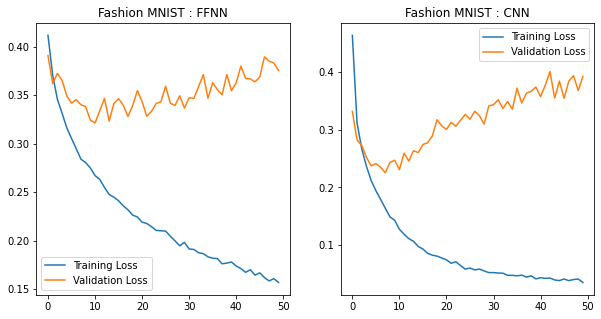

In [109]:
title=['FFNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title('Fashion MNIST : '+title[idx-1])
  idx+=1
  plt.legend();